<hr>
<h2>Multilinear Regression Analysis for Predicting CO2 Emissions in Light-Duty Automobiles</h2>
<hr>
<h3>Introduction</h3>

Over the last half-century, the mitigation of global warming has been of concern due to its capacity to compromise hospitable environmental conditions. It is therefore crucial to identify and understand factors contributing to global warming such that effective strategies to combat it may be synthesized. Greenhouse gases including carbon dioxide (CO2), methane, and chlorofluorocarbons are key contributors to global warming. The greenhouse gases absorb energy within the earth's atmosphere as near infrared light, mitigating its emission into space. This asorbed energy may be emitted from the molecules back into the atmosphere as heat, raising the earth's temperature akin to the functionality of a greenhouse. Although this phenomenon is necessary for maintaing temperatures suitable for life, its contributions to global warming have been magnified due to industrialization across the planet.

An avenue to reduce greenhouse gas emissions is to provide platforms to assess and compare the environmental impact of consumer-facing technologies. CO2 is the predominant greenhouse gas released by human enterprises, and it is primarily emitted by the burning of fossil fuels across many sectors including transportation, industrial processing, and electricity generation.[1] Although many factors (e.g. cost, fuel efficiency, size, etc.) drive the choice in purchasing vehicles, knowledge of anticipated CO2 emissions based on the automobile's parameters (e.g. engine size, number of cylinders, fuel consumption) could serve as an additional label to influence purchasing decisions with environmental benefit. 

Here, Scikit-learn is utilized to implement multiple linear regression analysis of CO2 emissions from light-duty vehicles available for retail sale in Canada. The publicly-available dataset[2] contains information on vehicle fuel consumption and CO2 emission. The data is divided into a train/test split, and a multiple linear regression model is trained on the training set to predict the CO2 emissions based on other vehicular parameters. Finally, the model is evaluated via the Mean Squared Error (MSE) and R^2 statistic.

<hr>

In [20]:
# Import packages:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error ,r2_score
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [ ]:
# Read dataset files:
path = (

)

df = pd.read_csv(path + 'MY2010-2014 Fuel Consumption Ratings 5-cycle.csv', encoding = 'ANSI')
# df.shape  # (5385, 221) raw shape

# Drop extra columns beyond CO2 emissions and bottom rows with annotations:
df.drop(df.columns[13: 221], axis = 1, inplace = True)  # empty columns
df.drop(df.index[5360: 5385], axis = 0, inplace = True)  # bottom annotations
df.drop(df.index[0], axis = 0, inplace = True)  # extra row due to formatting
# df.drop(df.columns[12], axis = 1, inplace = True)  # omit 'mpg' column

# Rename the column labels:
dfColumnLabels = [
    'MODELYEAR', 'MAKE', 'MODEL', 'VEHICLECLASS', 'ENGINESIZE',
    'CYLINDERS', 'TRANSMISSION', 'FUELTYPE', 'FUELCONSUMPTION_CITY',
    'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB', 'MPG',
    'CO2EMISSIONS'
]

df.columns = dfColumnLabels
df.shape  # (5359, 12)

df.head()

<hr>
<h3>Dataset Information</h3>

<u>Table 1: Variable Information</u>
| Variable | Description | Unit | Example Value |
| --- | --- | --- | --- |
| Model Year | Year of manufacture | year | 2010 |
| Make | Vehicle manufacturer | n/a | Hyundai |
| Model | Vehicle model | n/a | Sonata |
| Vehicle Class | Type of vehicle | n/a | Compact |
| Engine Size | Volume of engine | L | 3.7 |
| Cylinders | Number of engine cylinders | n/a | 4 |
| Transmission | Type of transmission | n/a | A6: automatic, 6 gears
| Fuel consumption - city | Fuel for city driving | L/100 km | 10.9 |
| Fuel consumption - highway| Fuel for highway driving | L/100 km | 7.8 |
| Fuel consumption - combined| 55% city/45 % highway driving combination | L/100 km | 9.5 |
| MPG | Miles per gallon, calculated from combined fuel consumption | miles/gallon | 30 |
| CO2 Emissions| CO2 emitted per mile driven | g/kme | 219 |


In [22]:
# Check data makeup of the dataframe:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5359 entries, 1 to 5359
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MODELYEAR             5359 non-null   object 
 1   MAKE                  5359 non-null   object 
 2   MODEL                 5359 non-null   object 
 3   VEHICLECLASS          5359 non-null   object 
 4   ENGINESIZE            5359 non-null   object 
 5   CYLINDERS             5359 non-null   float64
 6   TRANSMISSION          5359 non-null   object 
 7   FUELTYPE              5359 non-null   object 
 8   FUELCONSUMPTION_CITY  5359 non-null   object 
 9   FUELCONSUMPTION_HWY   5359 non-null   object 
 10  FUELCONSUMPTION_COMB  5359 non-null   object 
 11  MPG                   5359 non-null   object 
 12  CO2EMISSIONS          5359 non-null   object 
dtypes: float64(1), object(12)
memory usage: 544.4+ KB


Let's select some features that we want to use for regression.


In [23]:
# Convert model year, engine size, fuel consumption, mpg, and CO2 emissions to float64 data type:
floatDict = {
    'MODELYEAR': 'float64',
    'ENGINESIZE': 'float64',
    'CYLINDERS': 'float64',
    'FUELCONSUMPTION_CITY': 'float64',
    'FUELCONSUMPTION_HWY': 'float64',
    'FUELCONSUMPTION_COMB': 'float64',
    'MPG': 'float64',
    'CO2EMISSIONS': 'float64'
}

df = df.astype(floatDict)

df.dtypes
df.head(3)

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,MPG,CO2EMISSIONS
1,2010.0,ACURA,CSX,COMPACT,2.0,4.0,AS5,X,10.9,7.8,9.5,30.0,219.0
2,2010.0,ACURA,CSX,COMPACT,2.0,4.0,M5,X,10.0,7.6,8.9,32.0,205.0
3,2010.0,ACURA,CSX,COMPACT,2.0,4.0,M6,Z,11.6,8.1,10.0,28.0,230.0


In [24]:
# Categorize the transmission data into the 5 labels from the dataset:
# (A = Automatic, AM = Automated manual, AS = Automatic with select shift, AV = Continuously variable
# M = Manual)
df['TRANSMISSION'].replace(r'^A[0-9]$', 'Automatic', regex = True, inplace = True)  # A# pattern
df['TRANSMISSION'].replace(r'^AM[0-9]$', 'Automated Manual', regex = True, inplace = True)  # AM# pattern
df['TRANSMISSION'].replace(r'^AS[0-9]$', 'Automatic With Select Shift', regex = True, inplace = True)  # AS#
df['TRANSMISSION'].replace(r'^AV([0-9]|)$', 'Continuously Variable', regex = True, inplace = True)  # AV# pattern
df['TRANSMISSION'].replace(r'^M[0-9]$', 'Manual', regex = True, inplace = True)  # M# pattern

df['TRANSMISSION'].value_counts()

Automatic                      1965
Automatic With Select Shift    1770
Manual                         1157
Continuously Variable           331
Automated Manual                136
Name: TRANSMISSION, dtype: int64

In [25]:
# Relabel the fuel type with regular expressoins:
df['FUELTYPE'].replace(r'X$', 'Regular Gasoline', regex = True, inplace = True)
df['FUELTYPE'].replace(r'Z$', 'Premium Gasoline', regex = True, inplace = True)
df['FUELTYPE'].replace(r'D$', 'Diesel', regex = True, inplace = True)
df['FUELTYPE'].replace(r'E$', 'Ethanol E85', regex = True, inplace = True)

df['FUELTYPE'].value_counts()

Regular Gasoline    2663
Premium Gasoline    2125
Ethanol E85          481
Diesel                90
Name: FUELTYPE, dtype: int64

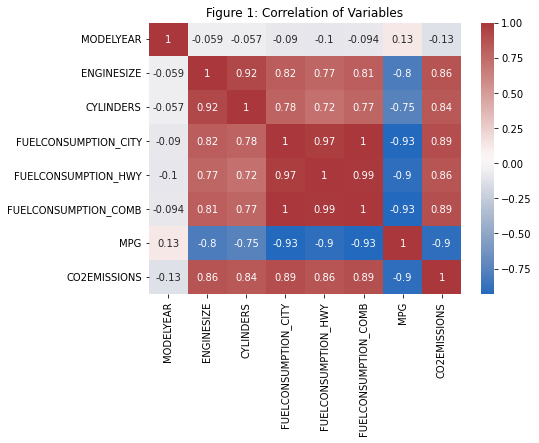

In [26]:
# Correlation heatmap of numerical feature variables:
corrMat = df.corr()
plt.figure(figsize = (7, 5))
sns.heatmap(corrMat, annot=True, cmap = 'vlag')
plt.title('Figure 1: Correlation of Variables')
plt.show()

In [27]:
# Drop model year because it is not highly correlated with CO2 emissions.
# Drop highway and city fuel consumption because they are highly correlated with each other.
# Drop MPG because it is calculated from the fuel consumption as a unit conversion and is the same information.
featureDf = df.copy()
featureDf.drop(
    ['MODELYEAR', 'FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY', 'MPG'],
    axis = 1, inplace = True)
featureDf.head()

,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_COMB,CO2EMISSIONS
1,ACURA,CSX,COMPACT,2.0,4.0,Automatic With Select Shift,Regular Gasoline,9.5,219.0
2,ACURA,CSX,COMPACT,2.0,4.0,Manual,Regular Gasoline,8.9,205.0
3,ACURA,CSX,COMPACT,2.0,4.0,Manual,Premium Gasoline,10.0,230.0
4,ACURA,MDX AWD,SUV,3.7,6.0,Automatic With Select Shift,Premium Gasoline,13.2,304.0
5,ACURA,RDX AWD TURBO,SUV,2.3,4.0,Automatic With Select Shift,Premium Gasoline,11.9,274.0


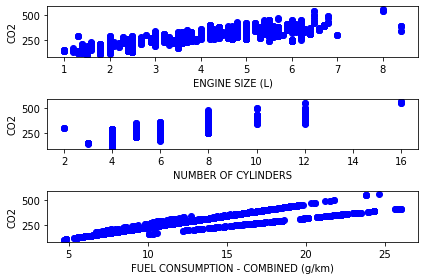

In [28]:
plt.subplot(3, 1, 1)
plt.scatter(featureDf.ENGINESIZE, featureDf.CO2EMISSIONS,  color='blue')
plt.xlabel('ENGINE SIZE (L)')
plt.ylabel('CO2')

plt.subplot(3, 1, 2)
plt.scatter(featureDf.CYLINDERS, featureDf.CO2EMISSIONS,  color='blue')
plt.xlabel('NUMBER OF CYLINDERS')
plt.ylabel('CO2')

plt.subplot(3, 1, 3)
plt.scatter(featureDf.FUELCONSUMPTION_COMB, featureDf.CO2EMISSIONS,  color='blue')
plt.xlabel('FUEL CONSUMPTION - COMBINED (g/km)')
plt.ylabel('CO2')

plt.tight_layout()
plt.show()

In [29]:
# Train/test split at 80/20:
X = featureDf[['ENGINESIZE', 'CYLINDERS']]
y = featureDf[['CO2EMISSIONS']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('X training set has ' + str(X_train.shape[0]) + ' observations.')
print('X test set has ' + str(X_test.shape[0]) + ' observations.')
print('y training set has ' + str(y_train.shape[0]) + ' observations.')
print('y test set has ' + str(y_test.shape[0]) + ' observations.')

X training set has 4287 observations.
X test set has 1072 observations.
y training set has 4287 observations.
y test set has 1072 observations.


In [30]:
# Fit the model:
lm1 = LinearRegression()  # instantiate the model class, no hyperparameters passed in (e.g. fit_intercept)
lm1 = lm1.fit(X_train, y_train)  # fit the instance on the training set data
lm1Coef = lm1.coef_
lm1Intercept = lm1.intercept_

print(
    f'Equation for multiple linear regression model 1: \n' +
    'y = ' + str(round(lm1Intercept[0], 2)) + ' + ' + str(round(lm1Coef[0][0], 2)) + '*(ENGINESIZE) + ' +
    str(round(lm1Coef[0][1], 2)) + '*(CYLINDERS)'
)

Equation for multiple linear regression model 1: 
y = 106.62 + 23.91*(ENGINESIZE) + 12.92*(CYLINDERS)


In [31]:
# Predict expected values using model lm1:
y_test_pred = lm1.predict(X_test)

<AxesSubplot:ylabel='Count'>

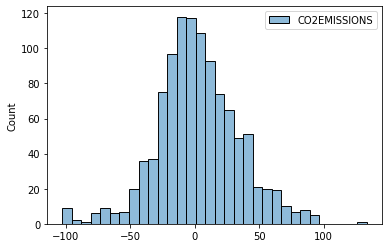

In [32]:
# Visualize residuals between y_test and predicted y values:
res = y_test - y_test_pred
# sns.distplot(res)
sns.histplot(res)

In [33]:
# Metrics for ml1 model from engine size and cylinder predictors:
print(f'R2 score: {r2_score(y_test, y_test_pred):.4f}')
print(f'Mean Squared Error: {mean_squared_error(y_test, y_test_pred):.2f}')

R2 score: 0.7377
Mean Squared Error: 1023.55


<hr>
Compare multiple linear regression model implementing FUELCONSUMPTION_COMB as feature variable:
<hr>

In [34]:
# Train/test split at 80/20:
X = featureDf[['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_COMB']]
y = featureDf[['CO2EMISSIONS']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('X training set has ' + str(X_train.shape[0]) + ' observations.')
print('X test set has ' + str(X_test.shape[0]) + ' observations.')
print('y training set has ' + str(y_train.shape[0]) + ' observations.')
print('y test set has ' + str(y_test.shape[0]) + ' observations.')

X training set has 4287 observations.
X test set has 1072 observations.
y training set has 4287 observations.
y test set has 1072 observations.


In [35]:
# Fit the model:
lm2 = LinearRegression()
lm2 = lm2.fit(X_train, y_train)
lm2Coef = lm2.coef_
lm2Intercept = lm2.intercept_

print(
    'Equation for multiple linear regression model 2: \n' +
    'y = ' + str(round(lm2Intercept[0], 2)) + ' + ' + str(round(lm2Coef[0][0], 2)) + '*(ENGINESIZE) + ' +
    str(round(lm2Coef[0][1], 2)) + '*(CYLINDERS) + ' + str(round(lm2Coef[0][2], 2)) + '*(FUELCONSUMPTION_COMB)'
)

Equation for multiple linear regression model 2: 
y = 63.66 + 8.22*(ENGINESIZE) + 9.32*(CYLINDERS) + 9.85*(FUELCONSUMPTION_COMB)


In [36]:
# Predict expected values using model lm2:
y_test_pred = lm2.predict(X_test)

<AxesSubplot:ylabel='Count'>

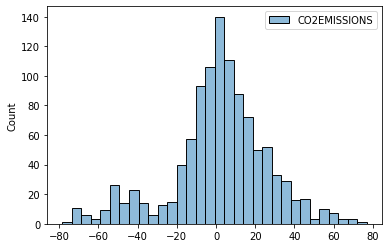

In [37]:
# Visualize residuals between y_test and predicted y values:
res = y_test - y_test_pred
# sns.distplot(res)
sns.histplot(res)

In [38]:
# Metrics for lm2 model from engine size, cylinder, and fuel consumption predictors:
print(f'R2 score: {r2_score(y_test, y_test_pred):.4f}')
print(f'Mean Squared Error: {mean_squared_error(y_test, y_test_pred):.2f}')

R2 score: 0.8432
Mean Squared Error: 611.83


<hr>
<h3>Model Results</h3>

<u>Table 2: Coefficient of Determination and Mean Squared Error</u>
| Predictor variables | Target variable | R^2 | MSE (Mean Squared Error) |
| --- | --- | --- | --- |
| ENGINESIZE, CYLINDERS | CO2EMISSIONS | 0.7377 | 1023.55 |
| ENGINESIZE, CYLINDERS, FUELCONSUMPTION_COMBINED | CO2EMISSIONS | 0.8432 | 611.83 |

<hr>
<h3 id='references'>References</h3>

[1] Zhou, Y.; Zhang, J.; Hu, S. Regression Analysis and Driving Force Model Building of CO2 Emissions in China. Sci Rep 2021, 11 (1), 6715. https://doi.org/10.1038/s41598-021-86183-5.
<br>
<br>
[2] https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64
<br>
<br>
<hr>